In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from data import *
from window import *
import matplotlib.pyplot as plt
import numpy as np

ticker = 'NDAQ'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)

print(data.columns)

[*********************100%%**********************]  1 of 1 completed
Index(['Open', 'High', 'Low', 'Close', 'RSI', 'MACD', 'MACD Signal', 'EMA_5',
       'EMA_8', 'EMA_13'],
      dtype='object')


In [4]:
def backtest_strategy(data):
    """ Simulate trading based on provided buy and sell signals, including tracking entry and exit prices. """
    capital = 10000
    shares = 0
    #create portforlio dataframe 
    portfolio = pd.DataFrame(index=data.index, columns=['Portfolio Value', 'Entry Price', 'Exit Price'])
    entry_price = None
    exit_price = None
    prev_signal = None 

    for row_index in range(0, len(data)): 
        signal = generate_signals(data, row_index)
    
        if signal == 'Buy' and prev_signal != 'Buy' and capital > 0:  # Check if signal is 'Buy' and different from previous
            shares_to_buy = capital / data.iloc[row_index]['Close']
            shares += shares_to_buy
            capital -= shares_to_buy * data.iloc[row_index]['Close']
            entry_price = data.iloc[row_index]['Close']
            portfolio.loc[data.index[row_index], 'Entry Price'] = entry_price
            # Reset exit price when entering a new position
            exit_price = None

        if signal == 'Sell' and prev_signal != 'Sell' and shares > 0:  # Check if signal is 'Sell' and different from previous
            capital += shares * data.iloc[row_index]['Close']
            shares = 0
            exit_price = data.iloc[row_index]['Close']
            portfolio.loc[data.index[row_index], 'Exit Price'] = exit_price
            # Reset entry price when exiting the position
            entry_price = None

        # Calculate portfolio value
        portfolio_value = capital + (shares * data.iloc[row_index]['Close'])
        portfolio.loc[data.index[row_index], 'Portfolio Value'] = portfolio_value
        
        prev_signal = signal  # Update previous signal for next iteration

    return portfolio.fillna(0)

# Running the backtest
data = fetch_data(ticker, start_date, end_date)

# Assuming generate_buy_signals and generate_sell_signals functions are defined
# and return lists of timestamps where signals occur

portfolio = backtest_strategy(data)

# Display results
print(portfolio)

[*********************100%%**********************]  1 of 1 completed
                     Portfolio Value  Entry Price  Exit Price
Datetime                                                     
2024-03-04 09:30:00     10000.000000     0.000000         0.0
2024-03-04 09:45:00     10000.000000   115.410004         0.0
2024-03-04 10:00:00      9846.633375     0.000000         0.0
2024-03-04 10:15:00      9766.917741     0.000000         0.0
2024-03-04 10:30:00      9740.057196     0.000000         0.0
...                              ...          ...         ...
2024-04-30 14:45:00      8885.796282     0.000000         0.0
2024-04-30 15:00:00      8885.796282     0.000000         0.0
2024-04-30 15:15:00      8885.796282     0.000000         0.0
2024-04-30 15:30:00      8885.796282     0.000000         0.0
2024-04-30 15:45:00      8885.796282     0.000000         0.0

[1066 rows x 3 columns]


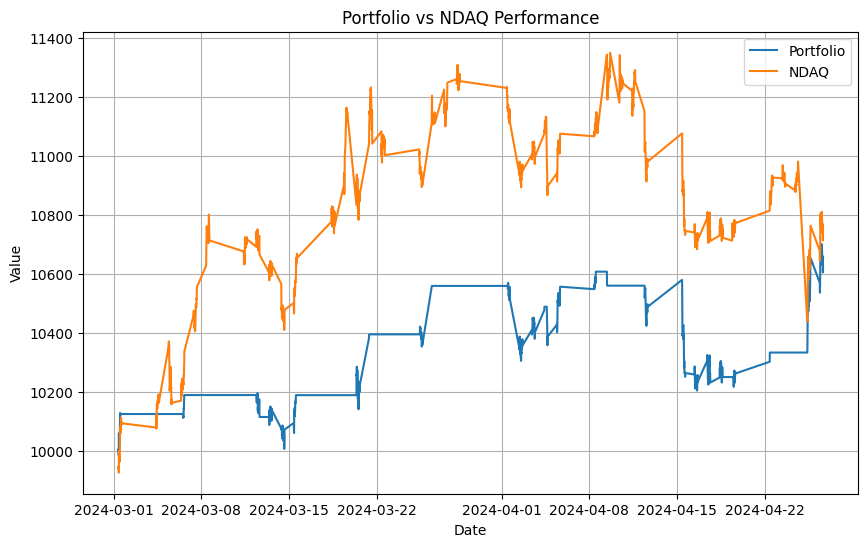

In [157]:
Ndaq_data = data['Close']*178.5

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Portfolio')
plt.plot(Ndaq_data.index, Ndaq_data, label='NDAQ')
plt.title('Portfolio vs NDAQ Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Already tried NDAQ (underperform), AAPL (Underperform)

In [142]:
ticker = 'TSLA'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)

portfolio = backtest_strategy(data)

[*********************100%%**********************]  1 of 1 completed


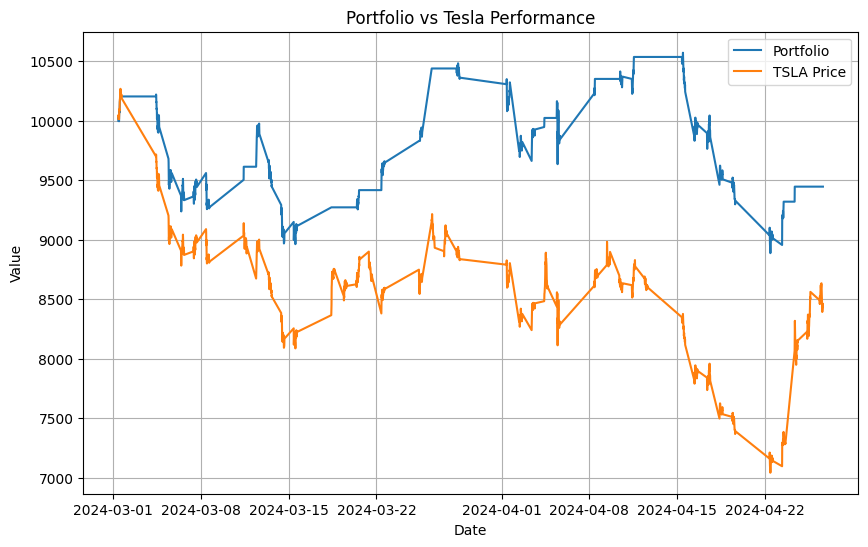

In [143]:
stock_data = data['Close']*50.27

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Portfolio')
plt.plot(stock_data.index, stock_data, label='TSLA Price')
plt.title('Portfolio vs Tesla Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [158]:
ticker = 'SPY'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)

portfolio = backtest_strategy(data)

[*********************100%%**********************]  1 of 1 completed


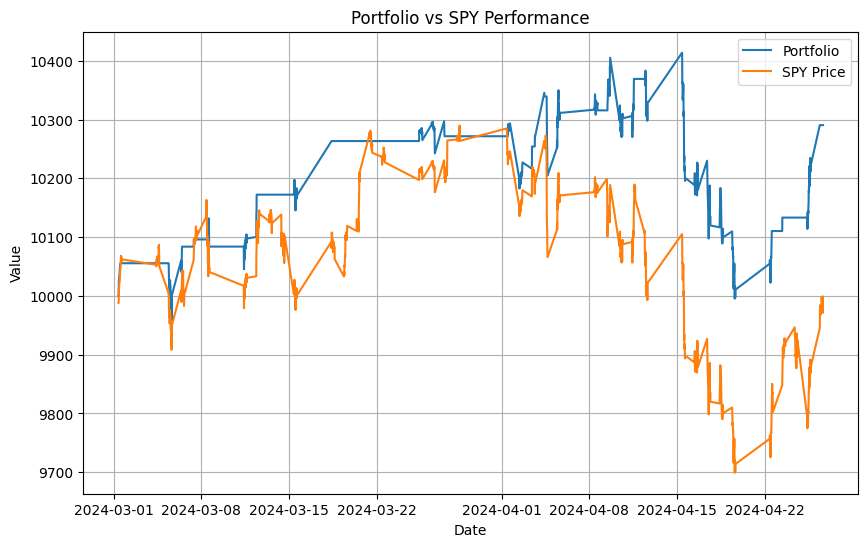

In [164]:
stock_data = data['Close']*19.62

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Portfolio')
plt.plot(stock_data.index, stock_data, label='SPY Price')
plt.title('Portfolio vs SPY Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%%**********************]  1 of 1 completed


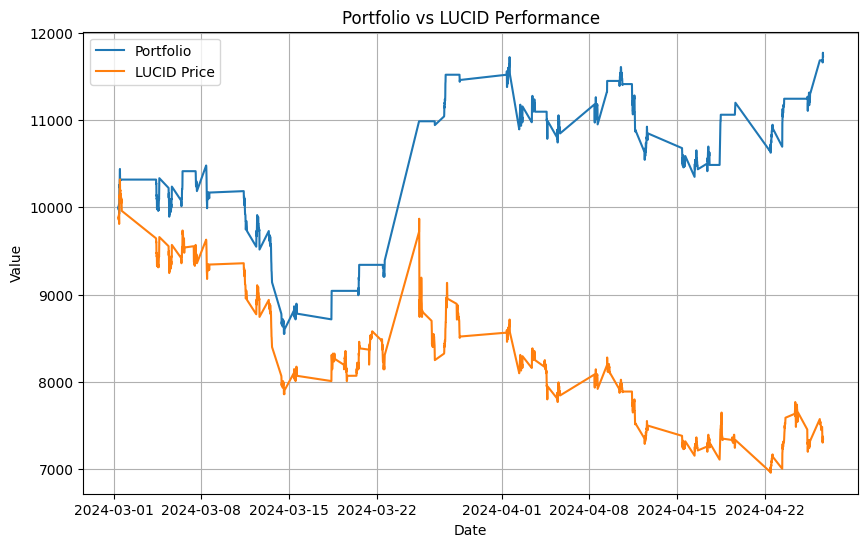

In [176]:
ticker = 'LCID'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)

stock_data = data['Close']*3000

portfolio = backtest_strategy(data)

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Portfolio')
plt.plot(stock_data.index, stock_data, label='LUCID Price')
plt.title('Portfolio vs LUCID Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%%**********************]  1 of 1 completed


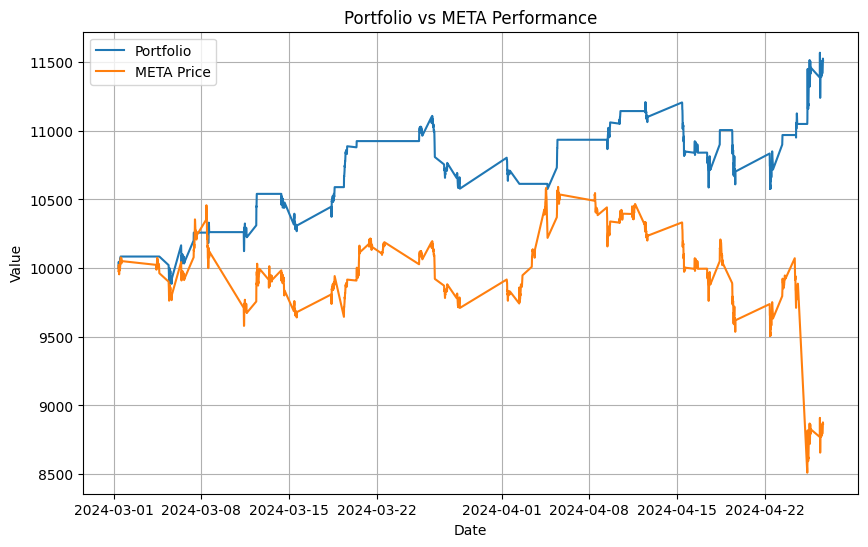

In [178]:
ticker = 'META'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)

stock_data = data['Close']*20

portfolio = backtest_strategy(data)

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Portfolio')
plt.plot(stock_data.index, stock_data, label='META Price')
plt.title('Portfolio vs META Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%%**********************]  1 of 1 completed


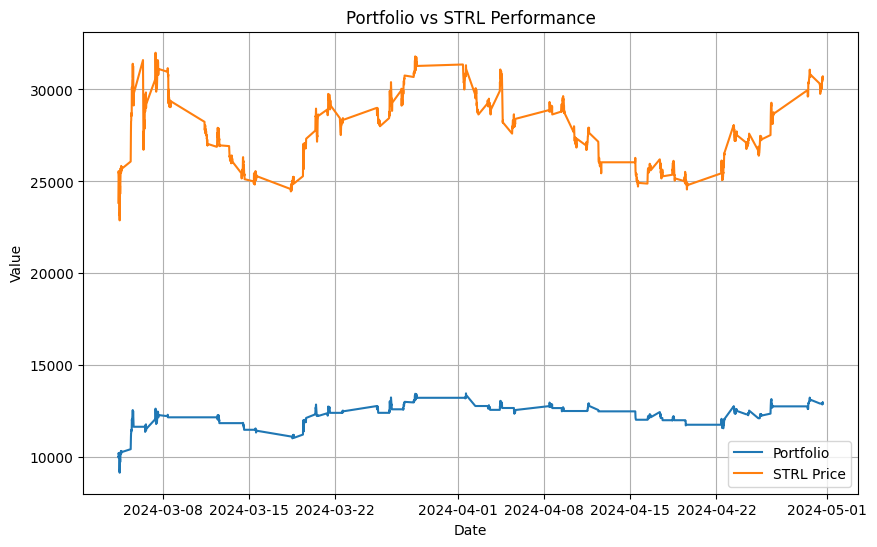

In [28]:
ticker = 'REAL'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)

stock_data = data['Close']*8000

portfolio = backtest_strategy(data)

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Portfolio')
plt.plot(stock_data.index, stock_data, label='STRL Price')
plt.title('Portfolio vs STRL Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()